# PINN for coupled Differential Equations

(Example problem taken from [https://math.libretexts.org/Bookshelves/Differential_Equations/Differential_Equations_(Chasnov)/07%3A_Systems_of_Equations/7.02%3A_Coupled_First-Order_Equations](https://math.libretexts.org/Bookshelves/Differential_Equations/Differential_Equations_(Chasnov)/07%3A_Systems_of_Equations/7.02%3A_Coupled_First-Order_Equations))

PINN to solve the following coupled differential equation

$$
\frac{dx_1(t)}{dt} = -\frac{1}{2}x_1(t) + x_2(t) 
$$

$$
\frac{dx_2(t)}{dt}= -x_1 - \frac{1}{2}x_2(t)
$$

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [13]:
class PINN(nn.Module):
    def __init__(
            self, 
            num_inputs: int=1,
            num_hidden_layers: int=1,
            num_neurons: int=1,
            num_outputs: int=1,
            activation: nn.Module = nn.Tanh()
    ):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden_layers = num_hidden_layers
        self.num_neurons = num_neurons
        self.num_outputs = num_outputs
        self.activation = activation

        layers = [nn.Linear(num_inputs, num_neurons)]

        for _ in range(num_hidden_layers):
            layers.append(activation)
            layers.append(nn.Linear(num_neurons, num_neurons))
        
        layers.append(activation)
        layers.append(nn.Linear(num_neurons, num_outputs))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [14]:
NUM_LAYERS = 7
NUM_NEURONS = 7
EPOCHS = 10000 #how many times the training step is performed
BATCH_SIZE = 50 # how many input values are considered for each epoch
LEARNING_RATE = 5e-3 #learning rate
TOLERANCE = 1e-4 # error tolerance
NUM_INPUTS = 1
NUM_OUTPUTS = 2

T_DOMAIN = (0.0, 20.0)
X1_DOMAIN = (-2.0, 2.0)
X2_DOMAIN = (-2.0, 2.0)

In [15]:

def loss_function(
        model: nn.Module, 
        t: torch.Tensor,
        bt: torch.Tensor, 
        bx: torch.Tensor,
    ) -> torch.Tensor:

    t.requires_grad_(True)
    
    output = model(t)
    x1_val = output[:, 0].unsqueeze(1)
    x2_val = output[:, 1].unsqueeze(1)

    dx1_dt = torch.autograd.grad(x1_val, t, grad_outputs=torch.ones_like(x1_val), create_graph=True)[0]
    dx2_dt = torch.autograd.grad(x2_val, t, grad_outputs=torch.ones_like(x2_val), create_graph=True)[0]

    de1 = dx1_dt + (1/2) * x1_val - x2_val
    de2 = dx2_dt + x1_val + (1/2) * x2_val
    
    bc = model(bt) - bx

    loss = torch.mean(de1**2) + torch.mean(de2**2) + torch.mean(bc**2)

    return loss

In [16]:
from IPython.display import clear_output

def train( # train the model for a given initial conditions and returns the predictions of the model
        x_0: tuple[float]
    ) -> tuple[torch.Tensor, torch.Tensor]:

    clear_output(wait=True)

    (x1_0, x2_0) = x_0 # initial boundary conditions
    print(x_0)
    X = PINN(num_inputs=NUM_INPUTS, num_hidden_layers=NUM_LAYERS, num_neurons=NUM_NEURONS, num_outputs=NUM_OUTPUTS)
    optimizer = optim.Adam(X.parameters(), lr=LEARNING_RATE)
    
    def train_step(model,input, bt, bx):
        optimizer.zero_grad()
        loss = loss_function(model, input, bt, bx)
        loss.backward()
        optimizer.step()

        return loss
    
    # input_batch = tf.linspace(T_DOMAIN[0], T_DOMAIN[1], BATCH_SIZE)
    
    for epoch in range(EPOCHS):
        input_batch =  torch.rand(BATCH_SIZE, NUM_INPUTS) * (T_DOMAIN[1] - T_DOMAIN[0]) + T_DOMAIN[0] 
        input_batch.requires_grad_(True)
        loss = train_step(X, input_batch, torch.tensor([0.0]), torch.tensor([x1_0, x2_0])) 
        
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Loss: {loss}')
        if loss <= TOLERANCE:
            break

    t_plot = torch.linspace(T_DOMAIN[0], T_DOMAIN[1], 1000).reshape(-1, 1)
    x_pred = X(t_plot)
    x1_pred = torch.index_select(x_pred, dim=1, index=torch.tensor([0]))
    x2_pred = torch.index_select(x_pred, dim=1, index=torch.tensor([1]))

    return (x1_pred, x2_pred)


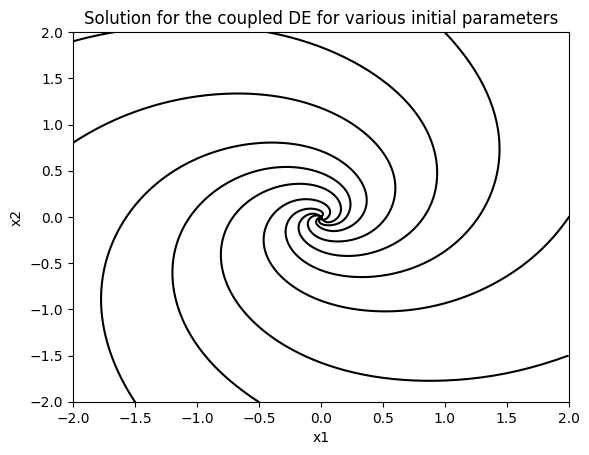

In [17]:
inits = [(2.0, 0.0), (2.0, -1.5), (-0.5, -2.0), (-1.5, -2.0), (-2.0, 0.8), (-2.0, 1.9), (1.0, 2.0)]

for init in inits:
    x1_pred, x2_pred = train(init)
    plt.plot(x1_pred.detach(), x2_pred.detach(), color='black')

clear_output()

plt.xlim(X1_DOMAIN[0],X1_DOMAIN[1])
plt.ylim(X2_DOMAIN[0],X2_DOMAIN[1])
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Solution for the coupled DE for various initial parameters")
plt.show()

## Analytical solution

(from the above given link)

![Analytical solution](coupled_analytical.png)